# Best Practices

In this notebook, we provide best practices for using the <a href="https://visym.github.io/collector/pip_175k/">PIP-175k</a> dataset for training on <a href="https://mevadata.org">MEVA</a>.

In [1]:
import vipy
assert vipy.version.is_at_least('1.9.5')

In [2]:
V = vipy.util.load('/Users/jba3139/Desktop/pip_175k/valset.pkl')

## 1. Use framewise labels

This dataset uses multi-label activities with dense bounding box annotations.  Each object may be performing zero or more activities simultaneously, and the framewise labels capture when an object is performing an activity in a given frame.  This means that a person can be simutaneously be performing two or more activities such as "person_talks_on_cellphone" and "person_opens_facility_door".  This can also manifest due to the MEVA annotation definitions, which can introduce overlapping activities such as "vehicle_dropping_off" and "vehicle_stopping". 

We recommend using the framewise labels to export tubelets of drforming bounding boxes over time for training.  Examples of extracting labels and boxes from the toolchain are shown below.

In [3]:
v = V[1].mindim(256).load()   # load a single video from the dataset
print(v)   # Each video has useful information when printed

<vipy.video.scene: height=256, width=256, frames=223, color=rgb, filename="/Users/jba3139/Desktop/pip_175k/videos/car_drops_off_person/778838D5-92E0-49DB-B1C9-AEB05669D125-3542-00000294C2F31029_1.mp4", fps=30.0, category="car_drops_off_person", objects=1, activities=3>


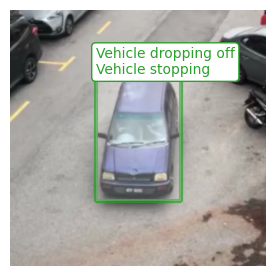

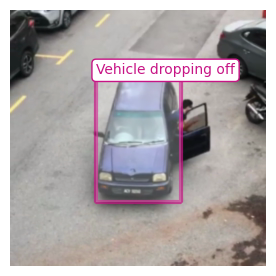

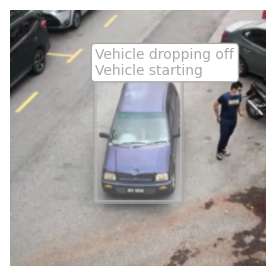

<vipy.image.scene: height=256, width=256, color=rgb, category="car_drops_off_person", objects=1>

In [4]:
v[0].show()   # show the first frame of video as an annotated image.  
v[100].show()   # 100th frame of video
v[200].show()   # 200th frame of video

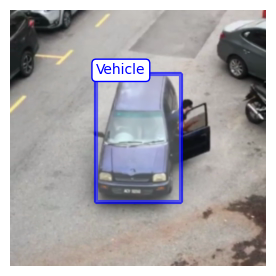

In [5]:
im = v[100][0].show()   # 100th frame, first object

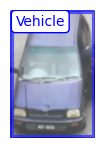

<vipy.image.imagedetection: height=128, width=85, color=rgb, category="Vehicle", bbox=(xmin=0.0, ymin=0.0, width=85.0, height=128.0)>

In [6]:
im.crop().show()  # crop this object using it's bounding box

In [7]:
im.boundingbox()   # return the bounding box for this object

<vipy.object.detection: category="Vehicle", bbox=(xmin=0.0, ymin=0.0, width=85.0, height=128.0)>

In [8]:
im.boundingbox().json()   # as JSON for portability

'{"_xmin":0,"_ymin":0,"_xmax":85,"_ymax":128,"_id":"ed38f3a9e7de4a07a915d9603cf542d1","_label":"Vehicle","_shortlabel":"Vehicle","_confidence":null,"attributes":{"trackid":"f9991ee6ecac11ea82acac1f6b2c363c","activityid":["f9991bb2ecac11ea82acac1f6b2c363c"],"noun verb":[["Vehicle",""],["Vehicle","dropping off"]]}}'

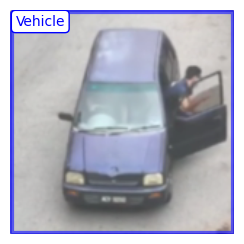

In [9]:
# make square, crop and resize to 224x224 
im = v[100][0].boxmap(lambda bb: bb.dilate(1.2).maxsquare()).crop().mindim(224).show()  

In [10]:
print(v.activitylabels(0))   # The labels in frame 0
print(v.activitylabels(100))  # in frame 100
print(v.activitylabels(200))  # in frame 200
[(k,lbl) for (k,lbl) in enumerate(v.label())]  # framewise labels

{'car_stops', 'car_drops_off_person'}
{'car_drops_off_person'}
{'car_starts', 'car_drops_off_person'}


[(0, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (1, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (2, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (3, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (4, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (5, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (6, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (7, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (8, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (9, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (10, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (11, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (12, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (13, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (14, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (15, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (16, {'Vehicle', 'car_drops_off_person', 'car_stops'}),
 (17, {'Vehicle', 'car_drops_off_person',

## 2. Use a multi-task loss

The use of joint activity labels means that activities can occur simulataneously.  A single actor can be performing more than one activity at the same time, which means that a loss that assumes one-hot ground truth labels is an inappropriate choice for training.  Instead, we recommend a framewise mutli-task loss that can be trained with multiple simulataneous labels per frame, such as binary cross-entropy.   

## 3.  Use your object proposals
We recommend runing your proposal generation pipeline on these videos and output your own object tracks for encoding the clips for training.  This will use the proper bounding box style for encoding tracks for representing activities.    
For example, you can run:

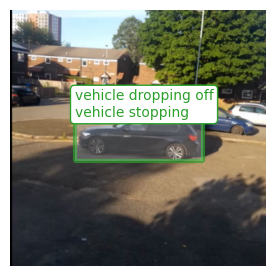

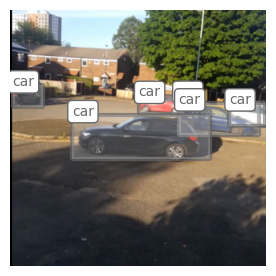

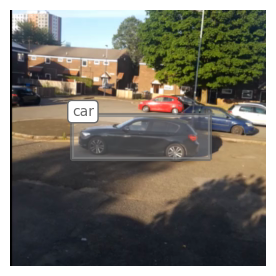

In [11]:
from pycollector.detection import ObjectDetector
detect = ObjectDetector()
for im in V[3].mindim(256).stream():
    im.show()                                  # the original labeled image
    imdet = detect(im).show()                  # the new detections
    imdet.intersection(im, miniou=0.8).show()  # the assignment of your detection to the truth
    break

## 4.  Use the Collector labels

Our collection platform includes additional labels that can aid in your training.  We subdivide broad classes into subclasses, which provide a more challenging task for training.  For example, we break out the broad class "person_puts_down_object" into "person_puts_down_object_on_shelf", "person_puts_down_object_on_floor" and "person_puts_down_object_on_table".  These are visually distinct activities, which can be rolled into a single class "person_puts_down_object", but we recommend training using the sub-classes to avoid overfitting.  Then, at test time, the original MEVA labels can be used.

Also, the collection platform includes additional weak labels that can aid in your training.  These labels are stored as metadata for each video and include:

* Collection name.  This is the description of the collection that is given to the collectors.  
* Collection date.  This is the local date time when the video was collected.  
* Geolocation.  This is the region of the world that the collection was recorded.  
* Collector ID.  This is a unique identifier for the collector who recorded the video.  
* Subject ID.   This is a unique identifier for the subject who is in the video.  
* Device ID.  This is mobile device type that was used to collect the original video.  
* Framerate.  This is the framerate at which the original video was collected.  

You can access this metadata by casting a video to a PyCollector Video objects.

In [12]:
from pycollector.video import Video
v = Video.cast(V[-1])
v.metadata()

{'collection_id': 'b37f9ace-77ea-4659-8781-5e59176dcd25',
 'video_id': 'E0E65439-B009-4215-9F95-BA19BC6A5CD8',
 'ipAddress': '109.245.32.25',
 'duration': 10,
 'app_version': '1.0.22',
 'os_version': '13.6.1',
 'collection_name': 'Unload something from a rear door',
 'program_name': 'MEVA',
 'device_identifier': 'ios',
 'subject_ids': ['10559b39-25a9-44bb-b9fa-44d6eb2e96ab'],
 'device_type': 'iPhone6S',
 'frame_rate': 29.974859795010634,
 'frame_width': 1080,
 'collected_date': '2020-08-23 06:36:46',
 'collector_id': '2c4dd6fd-b71a-4850-a688-f3b7761835d4',
 'blurred_faces': 0,
 'project_name': 'MEVA Car',
 'frame_height': 1920,
 'project_id': '4c66a969-892c-4114-b711-45b2af02244a',
 'orientation': 'portrait',
 'rotate': None}

In [13]:
v.geolocation()

{'ip': '109.245.32.25',
 'host': '109.245.32.25',
 'isp': 'Telenor d.o.o. Beograd',
 'city': 'Belgrade',
 'countrycode': 'RS',
 'countryname': 'Serbia',
 'latitude': '44.8166',
 'longitude': '20.4721'}

In [14]:
v.uploaded()

datetime.datetime(2020, 8, 23, 6, 36, 46, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>)

## 6.  Use background stabilized videos

Our pipelines support optical flow based stabilization of video.  This removes the artfacts due to hand-held cameras to stabilize the background.  Remaining artifacts are due to non-planar scenes and rolling shutter distortion.  You can use the attribute "stabilize" to filter on the stabilziation residual to filter out those videos with too large a distortion.

The pip-175k-stabilized release was constructed by running this stabilization on all videos and updating the object boxes accordingly.  You can run this yourself as shown below, or use the public release.

[vipy.flow.stabilize]: Affine coarse to fine stabilization ...


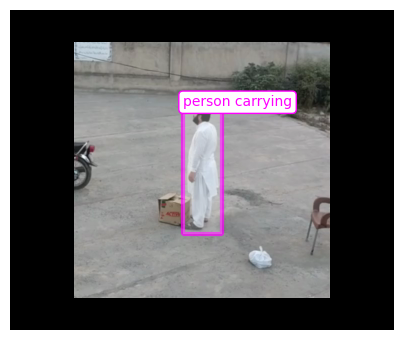

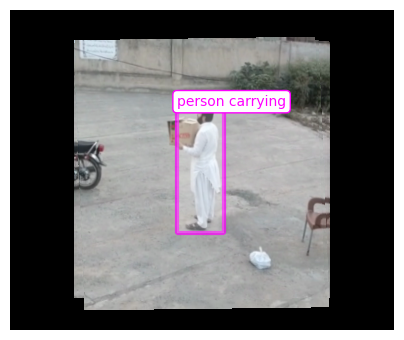

{'mean residual': 2.04874038171755, 'median residual': 0.2332429075248446}


In [15]:
d = vipy.util.groupbyasdict(V, lambda v: v.category())
v = d['person_carries_heavy_object'][1].mindim(256).stabilize()
v.frame(0).show()
v.frame(150).show()
print(v.getattribute('stabilize'))   # the stabilization residual for filtering poorly stabilized videos

## 7. Export to your pipeline

You can export torch or numpy arrays, or just transcode your videos for native ingestion into your pipeline.


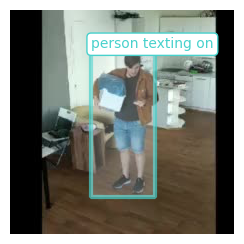

[vipy.video.annotate]: Annotating video ...


In [16]:
d = vipy.util.groupbyasdict(V, lambda v: v.category())
v = d['person_texts_on_phone'][0]
v = v.crop(v.trackbox().dilate(1.5).maxsquare()).mindim(224).saveas('/tmp/out.mp4')
v.thumbnail(frame=0).show()
v.show(notebook=True)

In [17]:
v.torch().shape    # export the transcoded video as a torch tensor

torch.Size([166, 3, 224, 224])

In [18]:
v.json()    # Export the metadata as a JSON encoded string

/Users/jba3139/dev/vipy/vipy/video.py:399: UserWarning: JSON serialization of video requires flushed buffers, will not include the loaded video.  Try store()/restore()/unstore() instead to serialize videos as standalone objects efficiently.
  warnings.warn("JSON serialization of video requires flushed buffers, will not include the loaded video.  Try store()/restore()/unstore() instead to serialize videos as standalone objects efficiently.")


'{"_filename":"\\/tmp\\/out.mp4","_url":null,"_framerate":30,"_array":null,"_colorspace":"rgb","attributes":{"blurred_faces":0,"collected_date":"2020-05-02 17:28:59","collection_id":"P004C007","collector_id":"8fd04a6f29","device_identifier":"android","device_type":"Mi A1","duration":18,"frame_height":640,"frame_rate":30.0,"frame_width":360,"orientation":"portrait","os_version":"28","project_id":"P004","subject_ids":["20200502_1728591507925914973165778"],"video_id":"20200502_1728591507925914973165778","rotate":null},"_startframe":null,"_endframe":null,"_endsec":null,"_startsec":null,"_ffmpeg":"ffmpeg -i \\/tmp\\/out.mp4 dummyfile","_category":"person_texts_on_phone","_tracks":{"9141e9f8eb5411ea9217ac1f6b2c363c":{"_id":"9141e9f8eb5411ea9217ac1f6b2c363c","_label":"person","_shortlabel":"person","_framerate":null,"_interpolation":"linear","_boundary":"strict","attributes":{},"_keyframes":[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,3